# Performance comparison

Here, we visualize the performance of three runtimes: PyTorch, our custom-built tinyRuntime (both non-quantized and quantized versions), using the ResNet18 model and 100 images from the Imagenette dataset. We focus on four key metrics: accuracy, execution time, model size and memory usage.

## x86

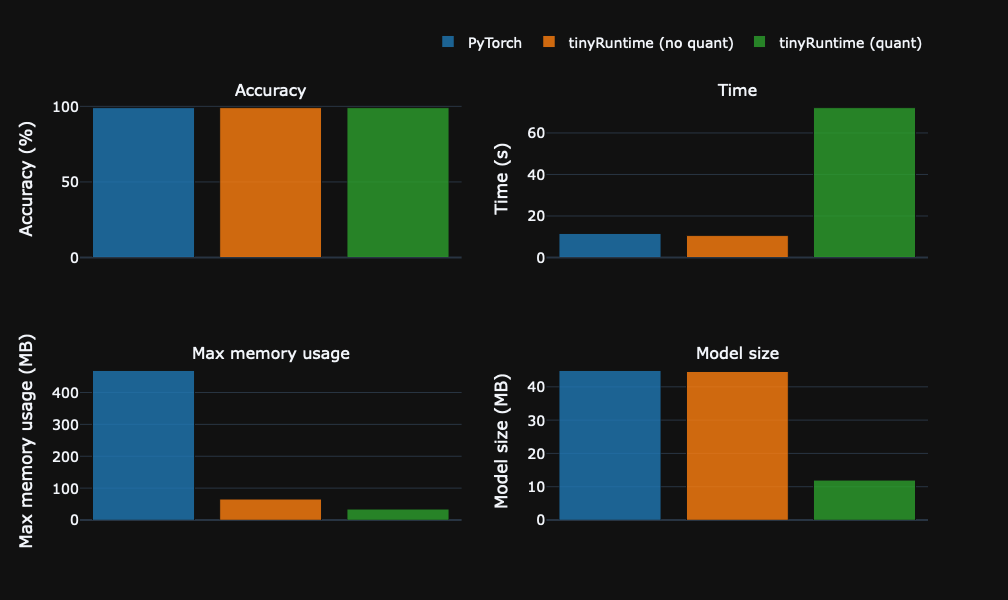

,Accuracy (%),Time (s),Max memory usage (MB),Model size (MB)
PyTorch,99.0,11.552532,469.382812,44.938353
tinyRuntime (no quant),99.0,10.451820,65.339844,44.660263
tinyRuntime (quant),99.0,72.082257,33.976562,11.949406


In [7]:
#| label: fig-x8
#| fig-cap: "Performance comparison on x86"

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

def split_dataframe(df):
    '''Split dataframe based on Runtime (Pytorch, tinyRuntime (no quant) and tinyRuntime (quant).'''
    df_pytorch = df[df["Runtime"] == "PyTorch"]
    df_trv = df[(df["Runtime"] == "tinyRuntime") & (df["Quantization"] == False)]
    df_trq = df[(df["Runtime"] == "tinyRuntime") & (df["Quantization"] == True)]
    return df_pytorch, df_trv, df_trq

def plot_perf_comp(df, theme):
    '''Plot latest performance comparisons using Plotly.'''
    dfs = split_dataframe(df)
    
    # Create subplots using Plotly Figure Factory
    fig = make_subplots(rows=2, cols=2, subplot_titles=("Accuracy", "Time", "Max memory usage", "Model size"))

    metrics = ["Accuracy", "Time", "Max memory", "Model size"]
    colors = ['rgba(31, 119, 180, 0.8)', 'rgba(255, 127, 14, 0.8)', 'rgba(44, 160, 44, 0.8)']
    names = ["PyTorch", "tinyRuntime (no quant)", "tinyRuntime (quant)"]

    for i, metric in enumerate(metrics):
        # Retrieve values for each metric
        y_values = [df[metric].values[-1] for df in dfs]
        
        # Add trace for each runtime
        for j, name in enumerate(names):
            trace = go.Bar(x=[name], y=[y_values[j]], marker_color=colors[j], showlegend=(i == 0), name=name)
            fig.add_trace(trace, row=i // 2 + 1, col=i % 2 + 1)

    # Set layout, background color and font size, and disable legend click feature
    fig.update_layout(
        legend=dict(orientation="h", yanchor="bottom", y=1.1, xanchor="right", x=1),height=600, width=900,
        template=theme, legend_itemclick=False, legend_itemdoubleclick=False, font=dict(size=14))

    # Update axis labels
    fig.update_yaxes(title_text="Accuracy (%)", row=1, col=1)
    fig.update_yaxes(title_text="Time (s)", row=1, col=2)
    fig.update_yaxes(title_text="Max memory usage (MB)", row=2, col=1)
    fig.update_yaxes(title_text="Model size (MB)", row=2, col=2)
    fig.update_xaxes(showticklabels=False)
    # Show the plot with modebar hidden
    fig.show(config={'displayModeBar': False})

    # Create DataFrame
    data = {
        "Accuracy (%)": [df["Accuracy"].values[-1] for df in dfs],
        "Time (s)": [df["Time"].values[-1] for df in dfs],
        "Max memory usage (MB)": [df["Max memory"].values[-1] for df in dfs],
        "Model size (MB)": [df["Model size"].values[-1] for df in dfs]
    }
    df_results = pd.DataFrame(data, index=["PyTorch", "tinyRuntime (no quant)", "tinyRuntime (quant)"])
    display(df_results)

df = pd.read_csv('benchmark.csv')
df_x86 = df[df["Architecture"] == "x86_64"]
plot_perf_comp(df_x86, "plotly_dark")

## ARM

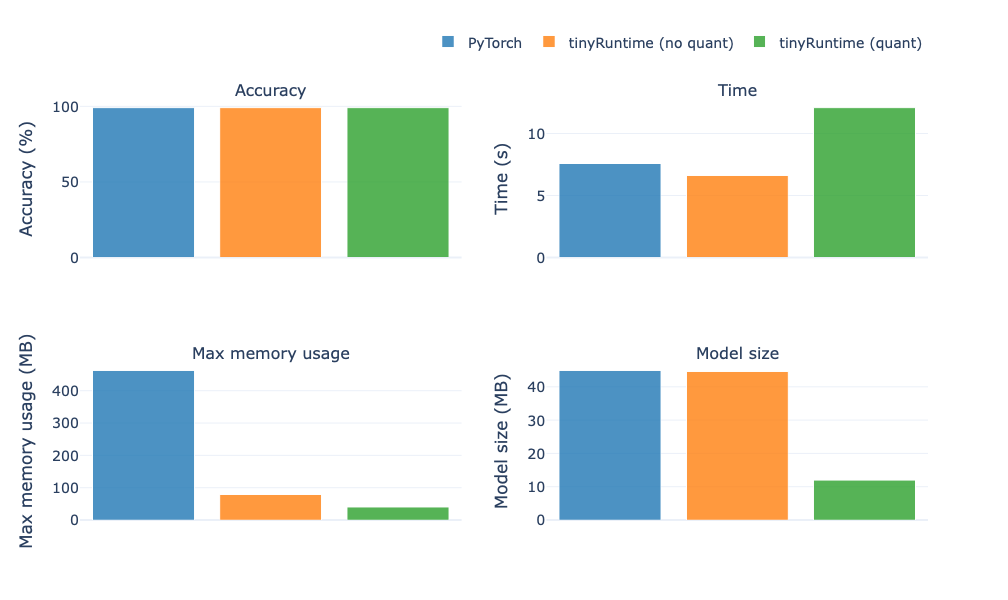

,Accuracy (%),Time (s),Max memory usage (MB),Model size (MB)
PyTorch,99.0,7.563920,462.953125,44.938353
tinyRuntime (no quant),99.0,6.604064,78.375000,44.660263
tinyRuntime (quant),99.0,12.067646,39.828125,11.949406


In [8]:
#| label: fig-arm
#| fig-cap: "Performance comparison on ARM"

df_arm = df[df["Architecture"] == "arm64"]
plot_perf_comp(df_arm, "plotly_white")

# Runtime Optimization Progress

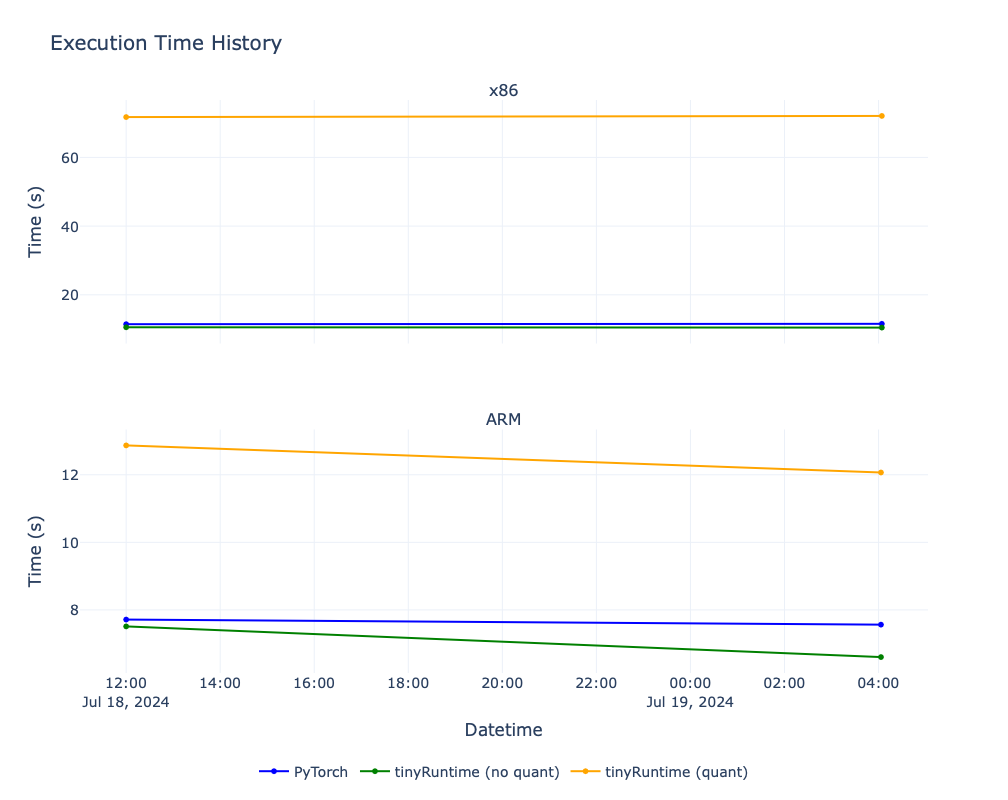

In [19]:
#| label: fig-time
#| fig-cap: "Time"

def plot_progress_subplot(fig, row, col, df, metric, showlegend):
    '''Plot evolution of execution time using Plotly.'''
    df_pytorch, df_trv, df_trq = split_dataframe(df)

    fig.add_trace(go.Scatter(x=df_pytorch["Datetime"], y=df_pytorch[metric], mode='lines+markers', name='PyTorch',
                             line=dict(color='blue'), showlegend=showlegend), row=row, col=col)
    fig.add_trace(go.Scatter(x=df_trv["Datetime"], y=df_trv[metric], mode='lines+markers', name='tinyRuntime (no quant)',
                             line=dict(color='green'), showlegend=showlegend), row=row, col=col)
    fig.add_trace(go.Scatter(x=df_trq["Datetime"], y=df_trq[metric], mode='lines+markers', name='tinyRuntime (quant)',
                             line=dict(color='orange'), showlegend=showlegend), row=row, col=col)

def plot_progress(metric, ylabel, title):
    fig = make_subplots(rows=2, cols=1, subplot_titles=('x86', 'ARM'), shared_xaxes=True, vertical_spacing=0.15)
    
    plot_progress_subplot(fig, 1, 1, df_x86, metric, showlegend=True)
    plot_progress_subplot(fig, 2, 1, df_arm, metric, showlegend=False)
    
    fig.update_xaxes(title_text="Datetime", row=2, col=1)
    fig.update_xaxes(showticklabels=False, row=1, col=1)
    fig.update_yaxes(title_text=ylabel, row=1, col=1)
    fig.update_yaxes(title_text=ylabel, row=2, col=1)
    
    fig.update_layout(height=800, width=1000, showlegend=True,
                      legend=dict(orientation="h", yanchor="bottom", y=-0.2, xanchor="center", x=0.5),
                      legend_itemclick=False, legend_itemdoubleclick=False, font=dict(size=14), margin=dict(t=100, b=50),
                      template="plotly_white", title=f"{title} History")
    fig.show(config={'displayModeBar': False})

plot_progress("Time", "Time (s)", "Execution Time")

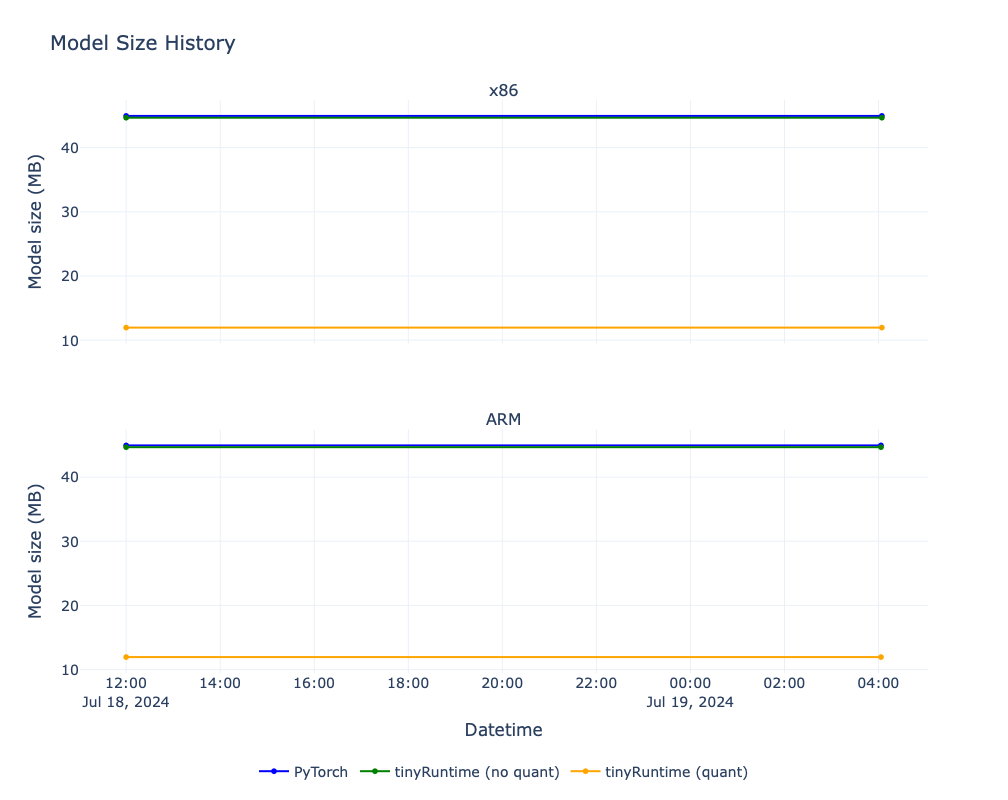

In [21]:
#| label: fig-modelsz
#| fig-cap: "Model size"

plot_progress("Model size", "Model size (MB)", "Model Size")

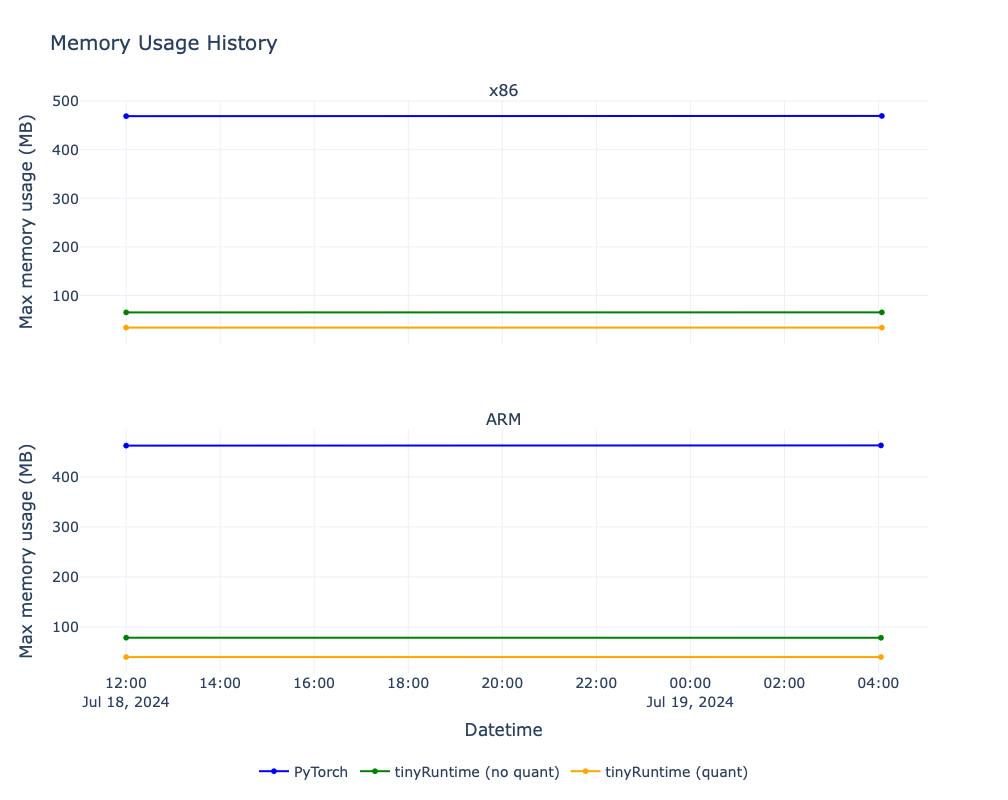

In [22]:
#| label: fig-memory
#| fig-cap: "Max memory usage"

plot_progress("Max memory", "Max memory usage (MB)", "Memory Usage")

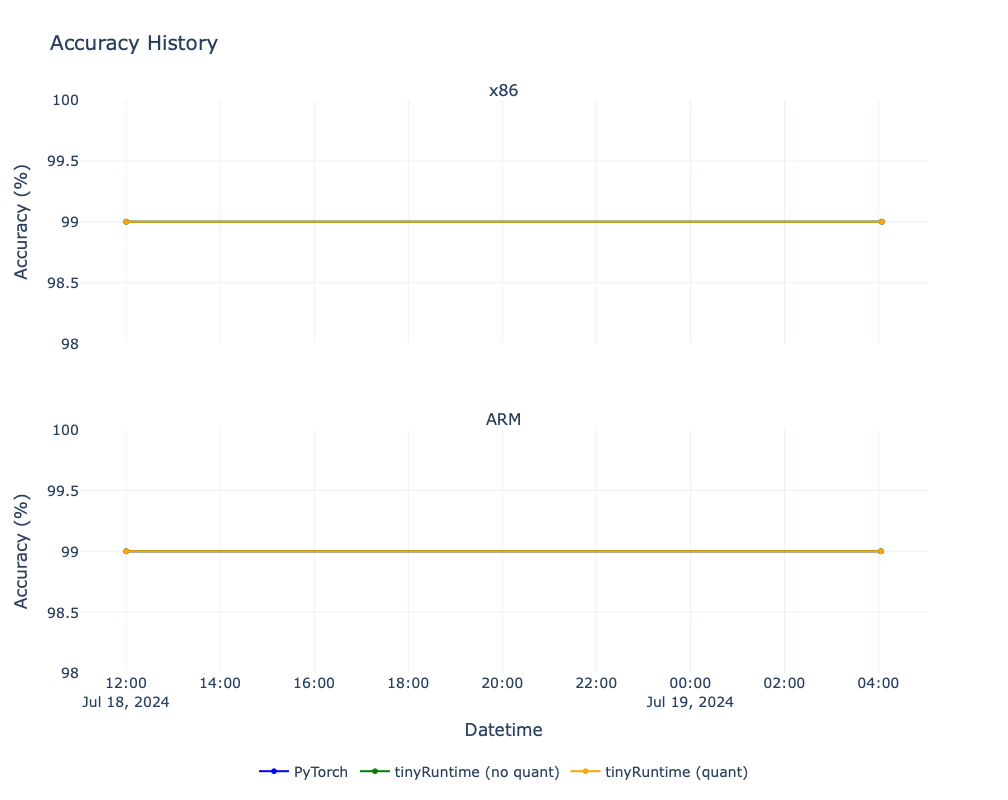

In [23]:
#| label: fig-accuracy
#| fig-cap: "Accuracy"

plot_progress("Accuracy", "Accuracy (%)", "Accuracy")